In [1]:
import scanpy as sc
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x', figsize=(3, 6))

In [2]:
from GEASO.utils.utils import split_slice, crop_slices, rigid_transformation

overlap_ratio = 0.3
theta = np.pi / 2

adata_all = sc.read_h5ad('E:/st_data/3D_rec/Spateo/partial/sagittal3.h5ad')
slices = split_slice(adata=adata_all, spatial_key='spatial_raw', split_num=4, axis=2)

slice1 = slices[1].copy()
slice2 = slices[2].copy()
slice1, slice2 = crop_slices(
    slice1,
    slice2,
    spatial_key='spatial',
    overlay_ratio=overlap_ratio,
)
rigid_transformation(slice2, 'spatial', 'spatial', theta=theta)

section_ids = ['slice1', 'slice2']
slice1.obs['batch'] = section_ids[0]
slice2.obs['batch'] = section_ids[1]

Training on cuda, please wait...


Epoch: 199, Loss: -434.633 step time=0.238s: 100%|██████████| 200/200 [00:48<00:00,  4.15it/s]


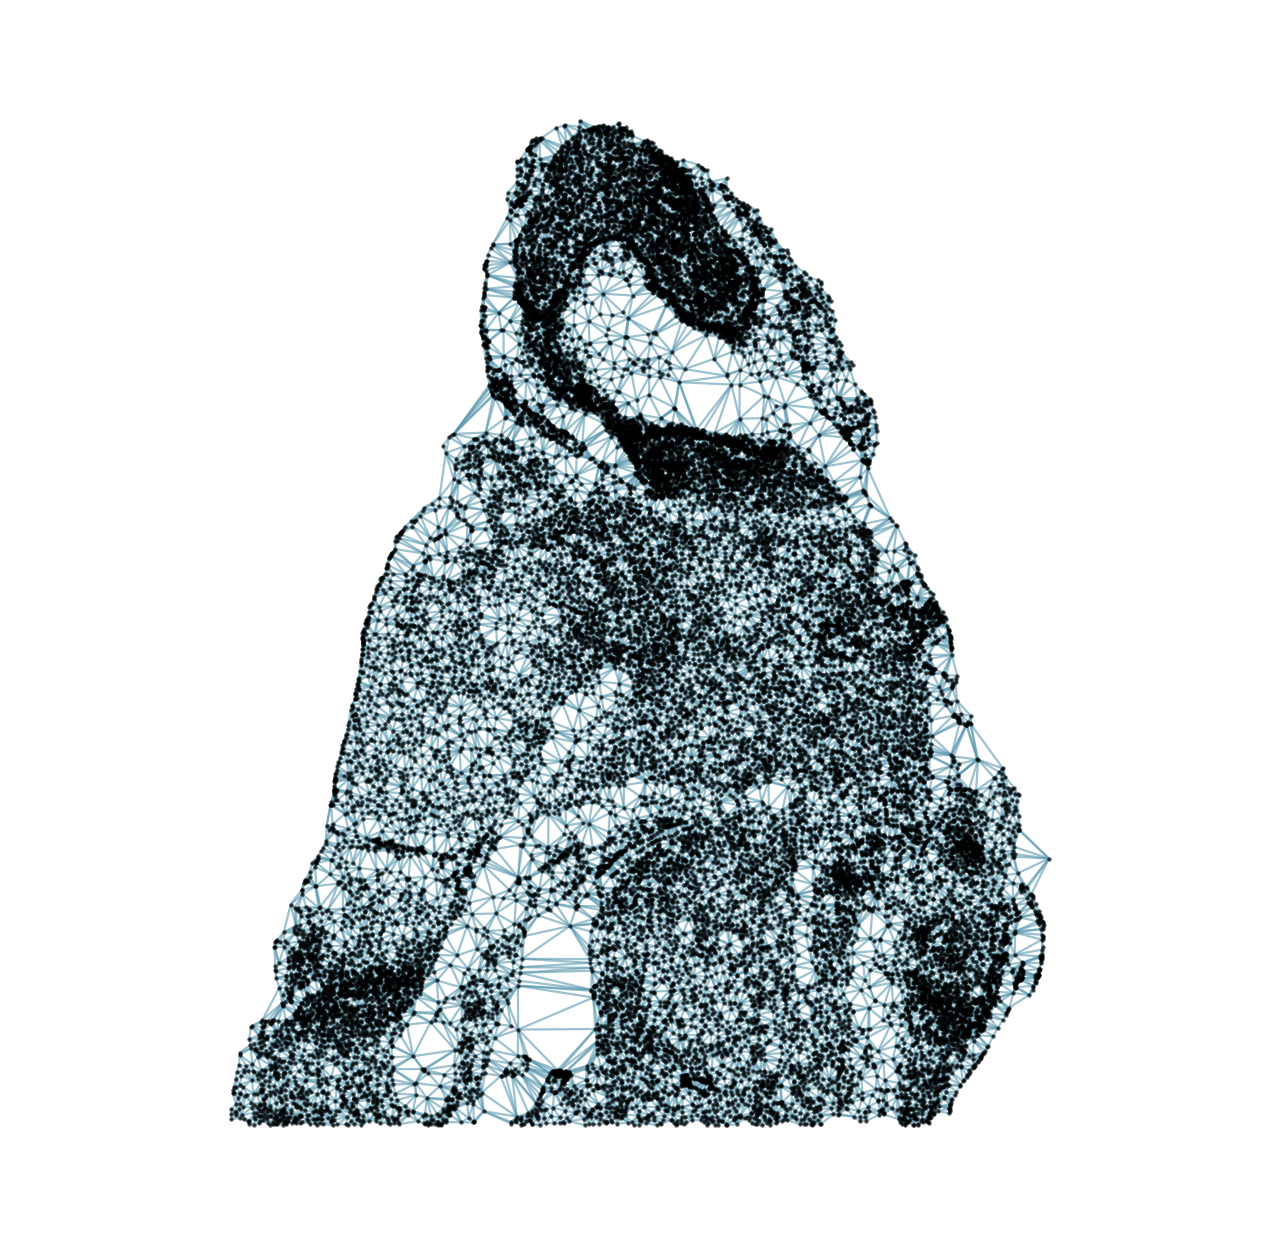

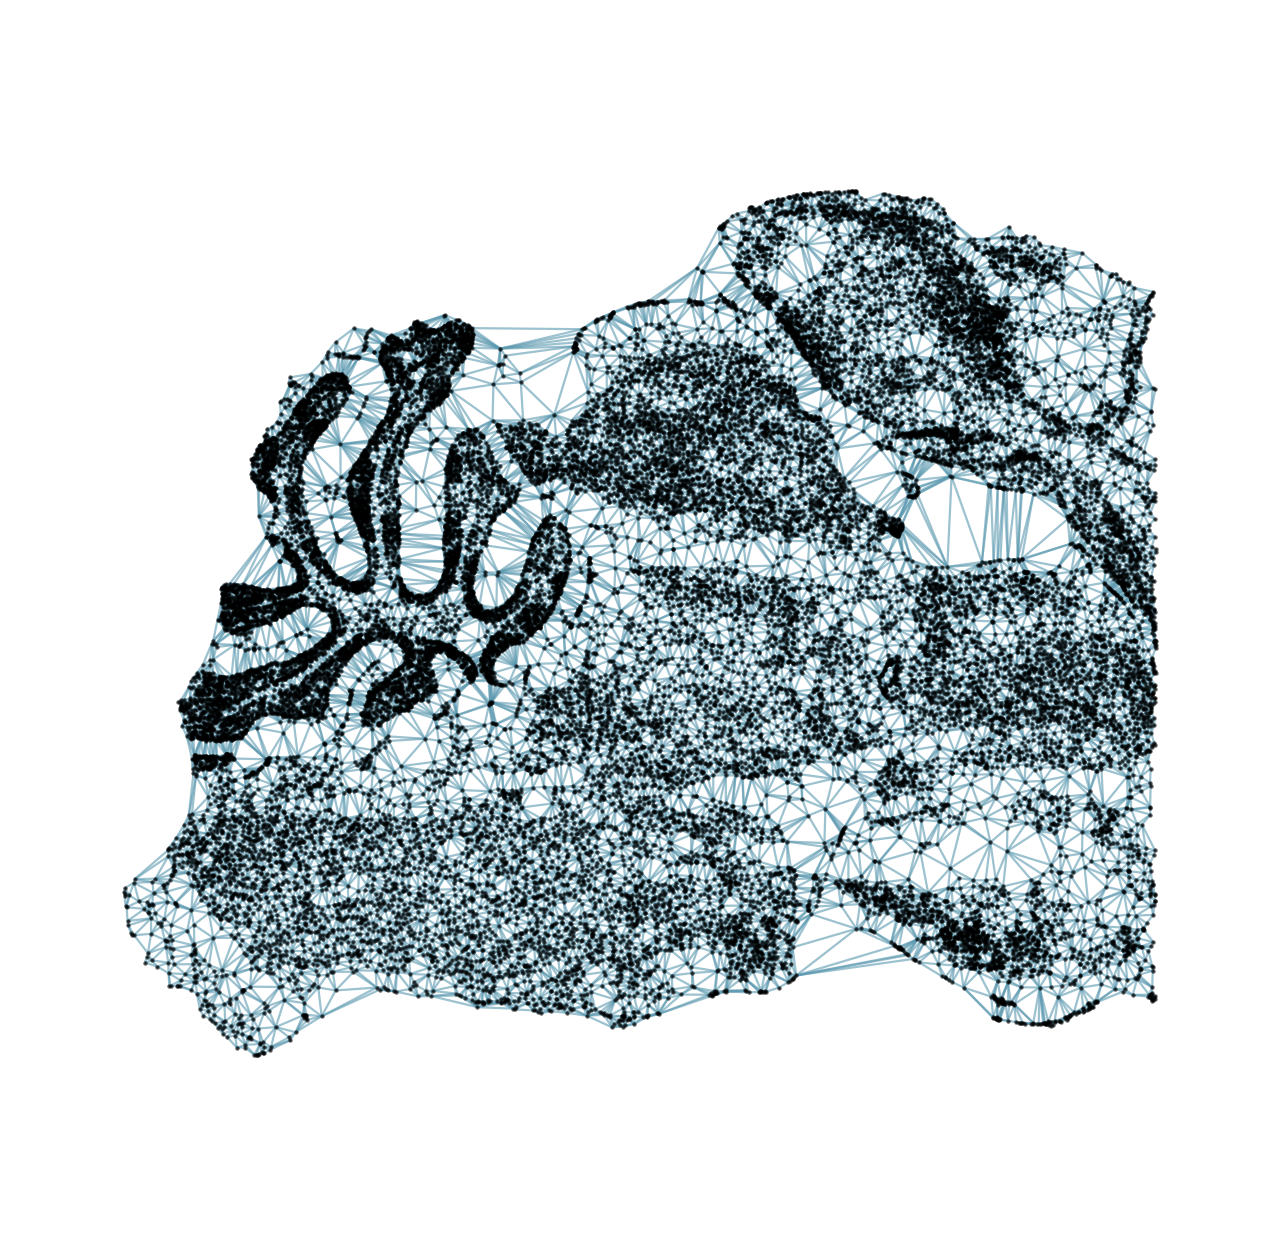

In [3]:
from GEASO.utils.utils import intersect, feature_extract

common_genes = intersect(slice1.var_names, slice2.var_names)
slice1 = slice1[:, common_genes]
slice2 = slice2[:, common_genes]

adata_list = [slice1, slice2]
emb_dict, loss_log, model = feature_extract(adata_list)
torch.cuda.empty_cache()

In [4]:
slice1.obsm['latent'] = emb_dict[section_ids[0]].cpu().numpy()
slice2.obsm['latent'] = emb_dict[section_ids[1]].cpu().numpy()

In [5]:
from GEASO.alignment.coarse_alignment import coarse_alignment

R, t, scale, P, spatial_scales, spatial_means, guided_source, guided_target, coarse_source, coarse_target = coarse_alignment(source=slice1, target=slice2, top_K=10, dis_metric='kl', use_latent=True, scale_c=False)

In [6]:
guided_source.shape

(41600, 2)

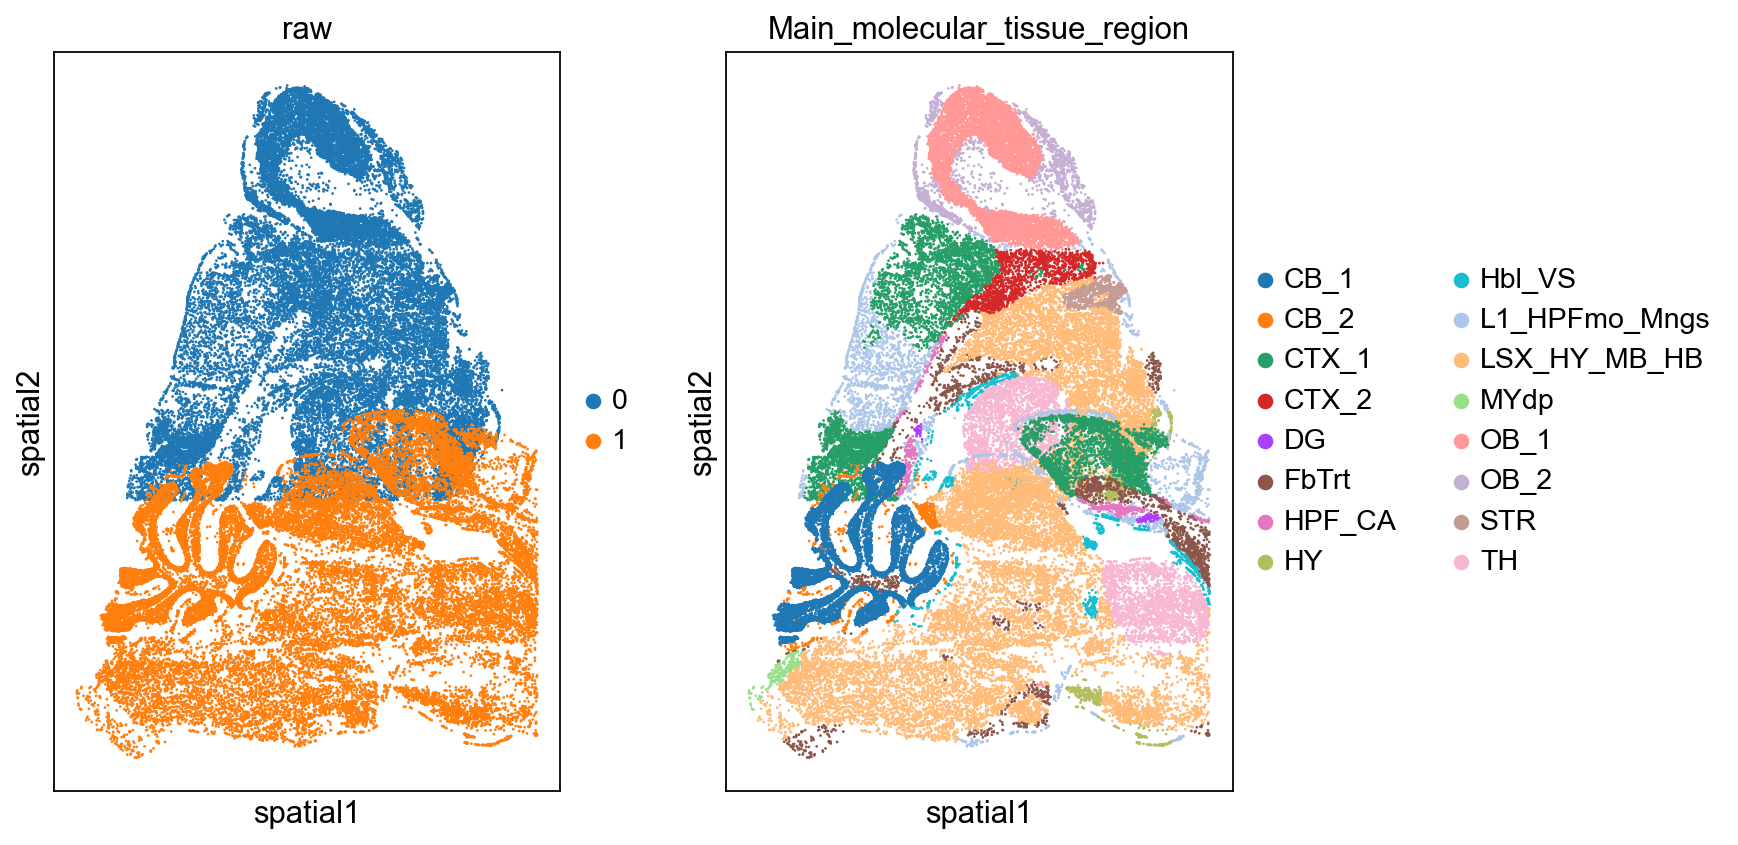

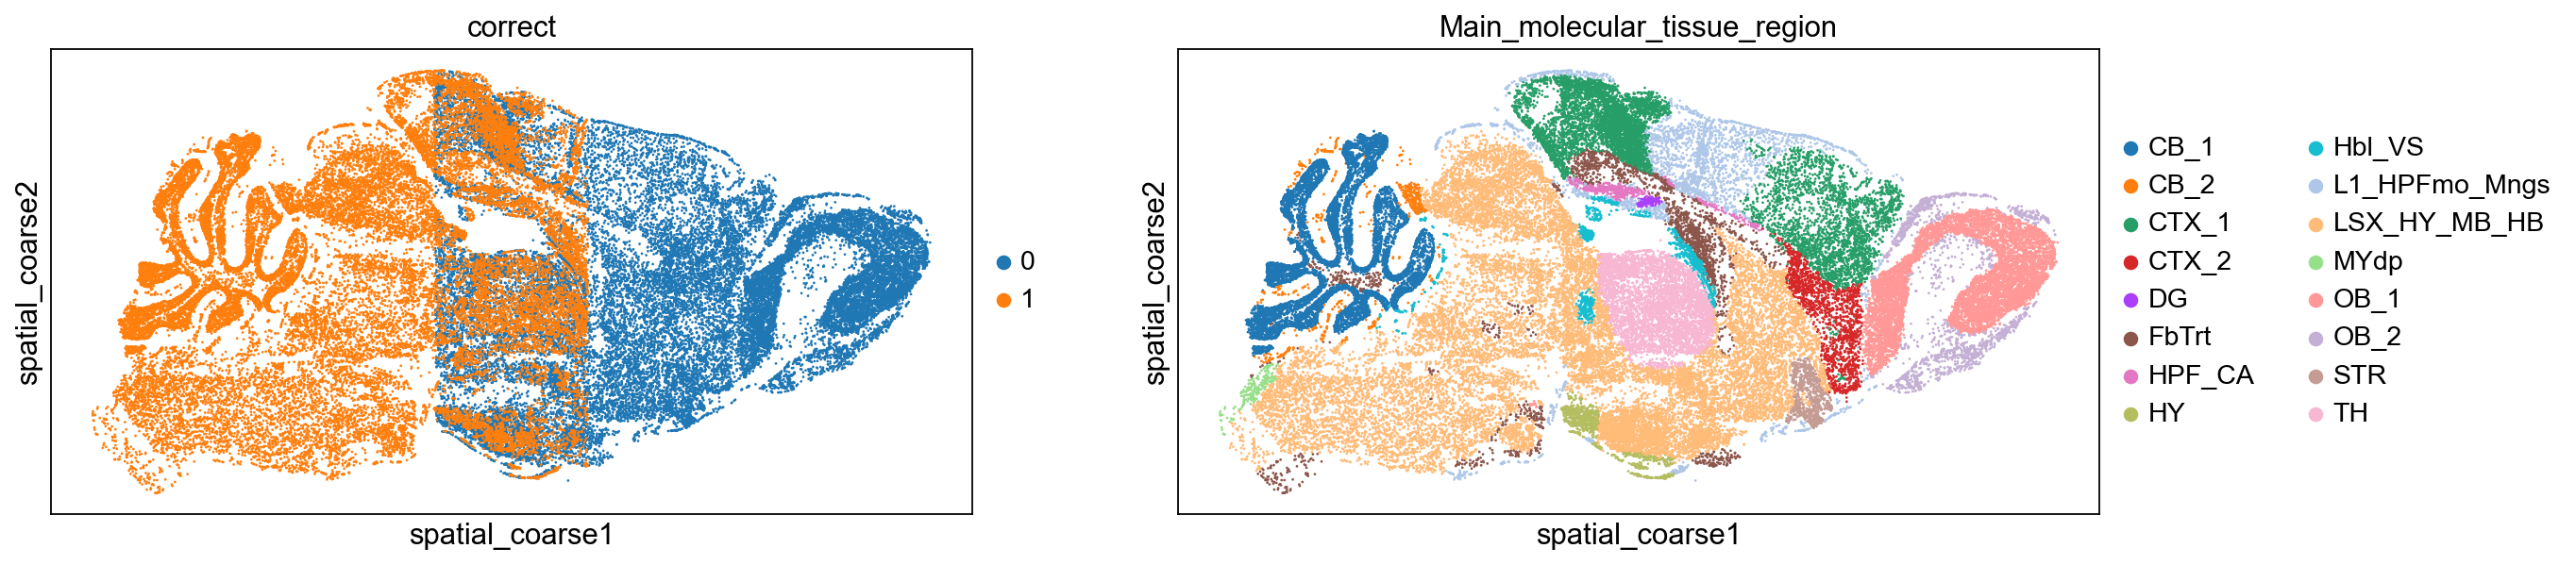

In [7]:
import anndata as ad

slice1.obsm['spatial_coarse'] = coarse_source.copy()
slice2.obsm['spatial_coarse'] = coarse_target.copy()

adata_cat = ad.concat([slice1, slice2], label='batch')

sc.set_figure_params(figsize=(4, 6))
sc.pl.embedding(adata_cat, basis='spatial', color=['batch', 'Main_molecular_tissue_region'], size=6, title='raw')

sc.set_figure_params(figsize=(8, 4))
sc.pl.embedding(adata_cat, basis='spatial_coarse', color=['batch', 'Main_molecular_tissue_region'], size=6, title='correct')

### Display overlap region

In [8]:
from typing import List
from scipy.spatial import Delaunay
from itertools import chain
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import polygonize, unary_union

def alpha_shape(points, alpha, only_outer=True) -> List:
    assert points.shape[0] > 3, "Need at least four points"
    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    circum_r_list = []
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]

        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        circum_r_list.append(circum_r)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    boundary = list(set(list(chain.from_iterable(list(edges)))))

    return boundary, edges, circum_r_list

def edges_to_polygon(points, edges):
    # 把每条边当成 LineString
    lines = [LineString([points[i], points[j]]) for i,j in edges]
    # 合并所有边并多边形化
    merged = unary_union(lines)
    polys = list(polygonize(merged))
    # 可能形成多个 Polygon，取最大的那个
    if len(polys) == 0:
        return None
    poly = max(polys, key=lambda p: p.area)
    return poly

def plot_alpha_shape(spatial_info, alpha=10):
    boundary, edges, _ = alpha_shape(spatial_info, alpha=alpha, only_outer=True)
    plt.scatter(spatial_info[:, 0], spatial_info[:, 1], s=0.5)
    for i, j in edges:
        plt.plot(spatial_info[[i, j], 0], spatial_info[[i, j], 1])
    plt.show()
    return boundary, edges

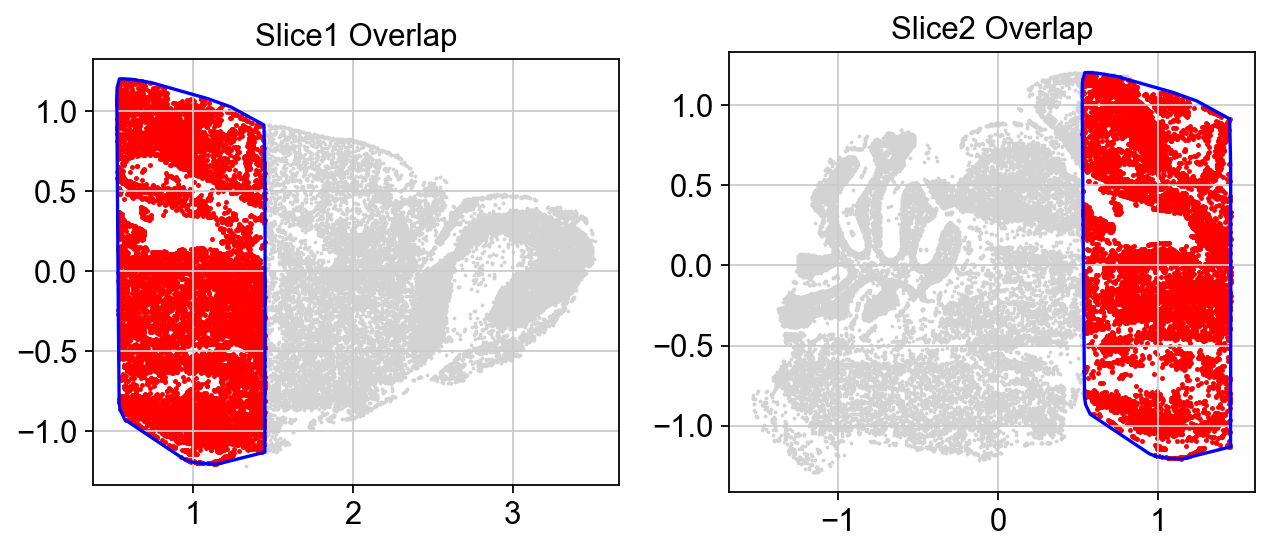

In [9]:
def mark_alpha_overlap(adata1, adata2, alpha1=100, alpha2=100):
    pts1 = np.asarray(adata1.obsm['spatial_coarse'][:, : 2])
    pts2 = np.asarray(adata2.obsm['spatial_coarse'][:, : 2])

    _, edges1, _ = alpha_shape(pts1, alpha=alpha1, only_outer=True)
    _, edges2, _ = alpha_shape(pts2, alpha=alpha2, only_outer=True)

    poly1 = edges_to_polygon(pts1, edges1)
    poly2 = edges_to_polygon(pts2, edges2)
    if poly1 is None or poly2 is None:
        raise ValueError("无法从 edges 构造 polygon，请检查 alpha 值或点的分布。")

    overlap_poly = poly1.intersection(poly2)
    mask1 = [overlap_poly.contains(Point(x,y)) for x,y in pts1]
    adata1.obs['alpha_overlap'] = mask1

    mask2 = [overlap_poly.contains(Point(x,y)) for x,y in pts2]
    adata2.obs['alpha_overlap'] = mask2

    fig, axes = plt.subplots(1,2, figsize=(8,4))
    for ax, pts, mask, title in zip(
        axes,
        [pts1, pts2],
        [mask1, mask2],
        ['Slice1 Overlap', 'Slice2 Overlap']
    ):
        ax.scatter(pts[:,0], pts[:,1], s=0.5, c='lightgrey')
        ax.scatter(pts[mask,0], pts[mask,1], s=1.5, c='red')

        x, y = overlap_poly.exterior.xy
        ax.plot(x, y, c='blue')
        ax.set_title(title)
        ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

mark_alpha_overlap(slice1, slice2, alpha1=1000, alpha2=1000)

### Perform elastic registration

In [14]:
from GEASO.alignment.elastic_registration import ElasticRegistration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
register_model = ElasticRegistration(
    init_P=P,
    guided_source=guided_source,
    guided_target=guided_target,
    source_slice=slice1,
    target_slice=slice2,
    normalize_scales=spatial_scales,
    normalize_means=spatial_means,
    spatial_key='spatial_coarse',
    dissimilarity='euc',
    device=device,
    max_iter=200,
)
torch.cuda.empty_cache()

Local structure kernel constructed with shape: torch.Size([32769, 100])


Slice Alignment: 100%|██████████| 200/200 [00:09<00:00, 21.26it/s]


In [15]:
slice1, slice2

(AnnData object with n_obs × n_vars = 32769 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice', 'batch', 'alpha_overlap'
     var: 'n_cells'
     uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
     obsm: 'X_pca', 'spatial', 'spatial_raw', 'latent', 'spatial_coarse', 'aligned_spatial_rigid', 'aligned_spatial_nonrigid'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 31283 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice', 'batch', 'alpha_overlap'
     var: 'n_cells'
     uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
     obsm: 'X_pca', 'spatial', 'spatial_raw', 'latent', 'spatial_coarse', 'aligned_spatial_rigid', 'aligned_spatial_nonrigid'
     varm: 'PCs'
     layers: 'counts')

In [16]:
slice2.obsm['aligned_spatial_rigid'] = slice2.obsm['spatial'].copy()
slice2.obsm['aligned_spatial_nonrigid'] = slice2.obsm['spatial'].copy()

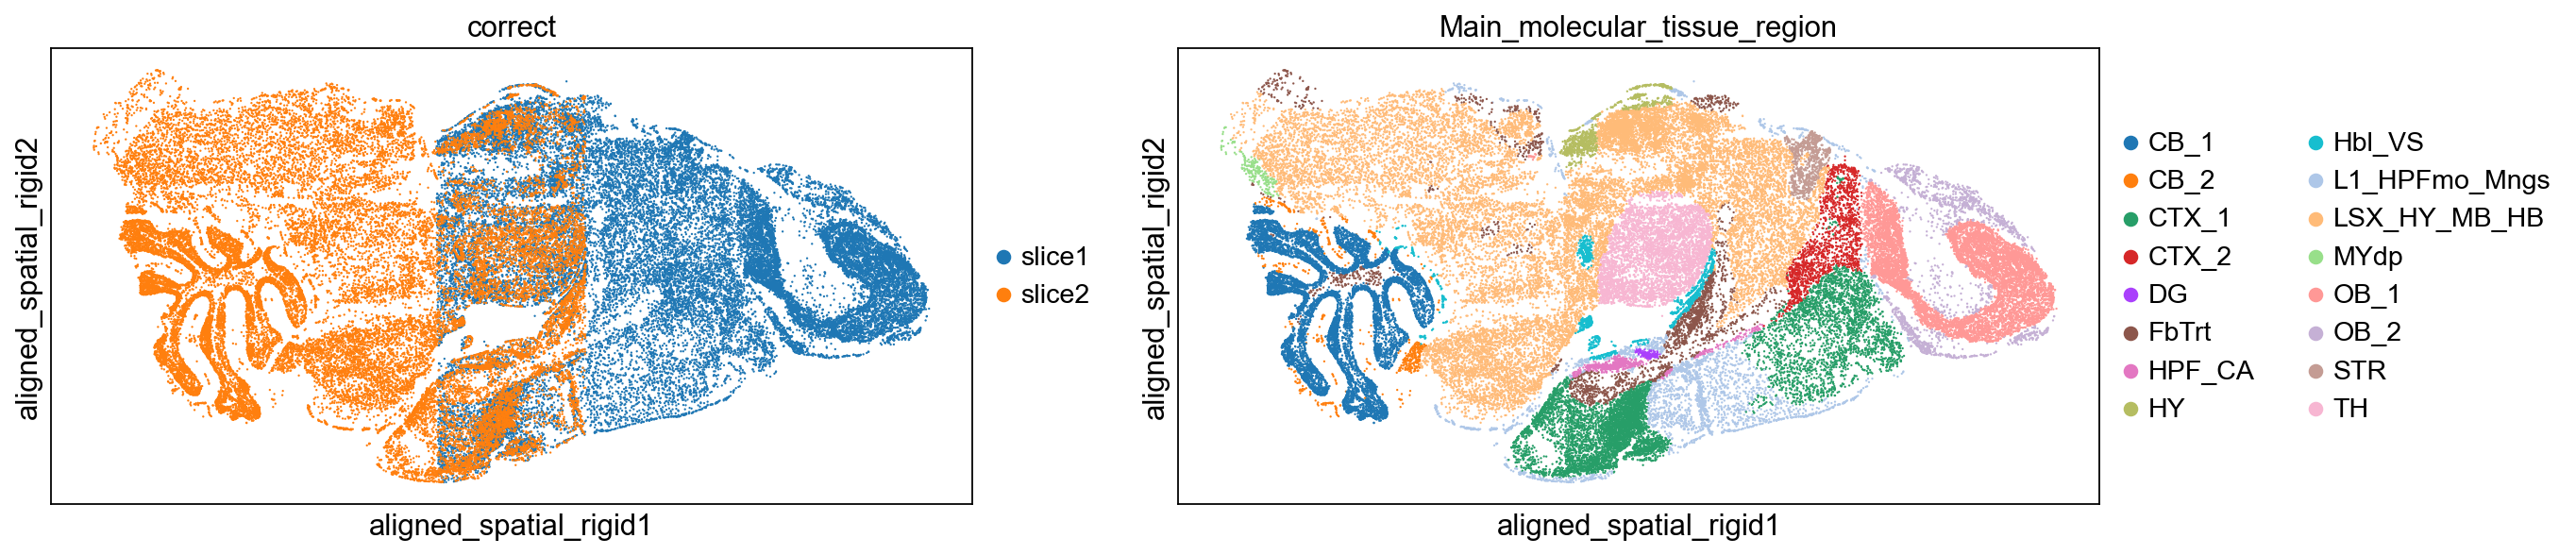

In [17]:
import anndata as ad

slice2.obsm['aligned_spatial_rigid'] = slice2.obsm['spatial'].copy()
adata_cat = ad.concat([slice1, slice2], label='batch', keys=['slice1', 'slice2'])
sc.pl.spatial(adata_cat, basis='aligned_spatial_rigid', color=['batch', 'Main_molecular_tissue_region'], spot_size=200, title='correct')

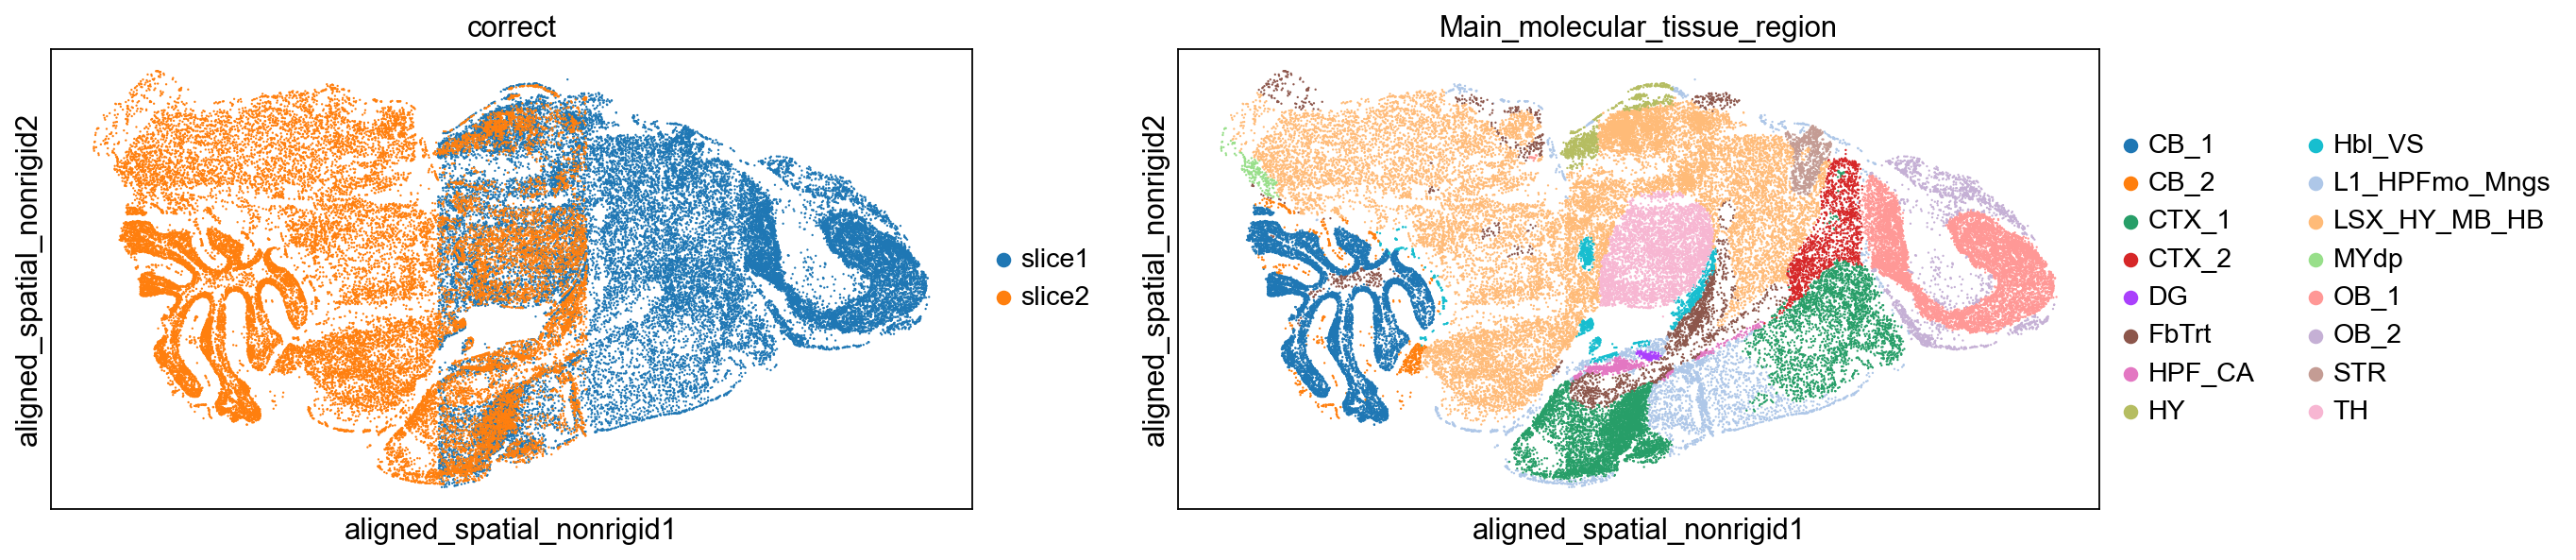

In [18]:
sc.pl.spatial(adata_cat, basis='aligned_spatial_nonrigid', color=['batch', 'Main_molecular_tissue_region'], spot_size=200, title='correct')